# Project 2 - Feature Selection

## Part 1
3 classifiers: LDA, CNN and kNN. 

2 feature selection methods: backward selection, lasso embedding.

In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F


### Importing the dataset

Here we have a dataset of cats (label 0) and dogs (label 1), images of size 64x64

In [39]:
df = pd.read_csv('catdogdata.txt', delimiter=' ')


df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries


df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096,label
1,23,23,20,20,9,9,9,4,4,4,...,108,108,108,89,65,51,31,23,9,0
2,250,250,250,244,244,244,244,244,232,232,...,244,244,232,244,244,244,244,232,244,0
3,137,137,137,144,151,151,151,158,151,151,...,89,89,78,78,78,100,102,124,124,0
4,55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,37,45,52,0
5,173,173,173,173,158,158,158,158,153,149,...,64,64,48,48,77,98,64,45,45,0


In [44]:
def plot_examples(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((64, 64))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

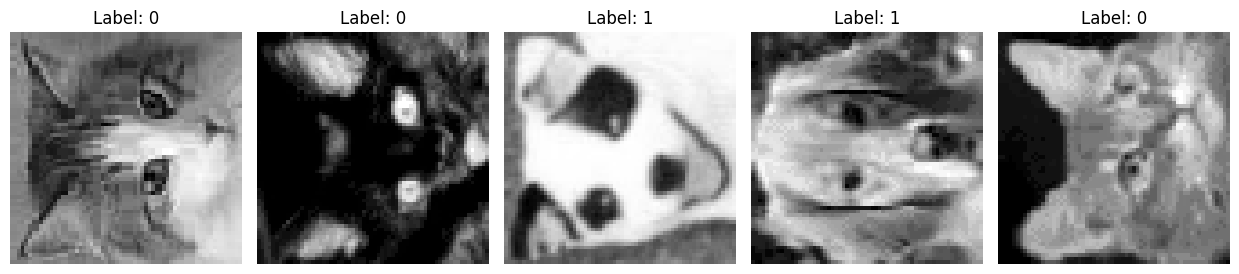

In [46]:
# plot example images
plot_examples(df, n=5)

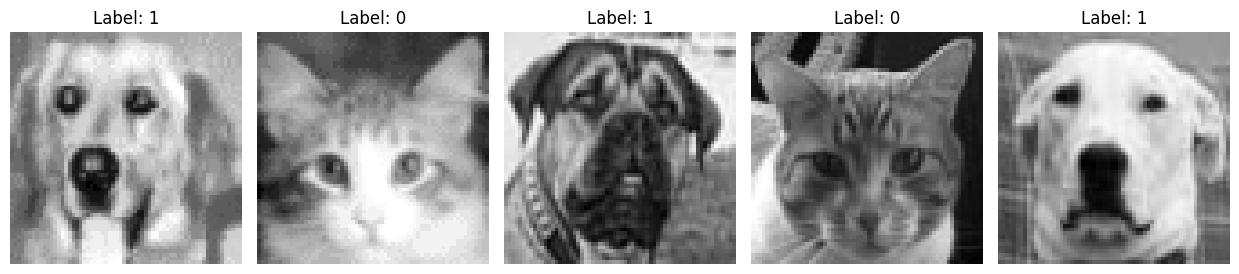

In [51]:
# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

# plot example images after rotation
plot_examples(df, n=5)

### Fixing the models

#### CNN

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy

class CNNclassifier(pl.LightningModule):
    def __init__(self, num_classes=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss, acc

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [101]:
# Load the data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Split the data into features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X = X.reshape(-1, 1, 64, 64)  # Reshape for CNN input

# Split the data into training and validation sets
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

print(f"Train set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 126
Validation set size: 32
Test set size: 40


In [102]:
# Initialize the model
model = CNNclassifier()

# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    logger=pl.loggers.TensorBoardLogger("logs/"),
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [103]:
# train the model
trainer.fit(model, train_loader, val_loader)

# Save the model
torch.save(model.state_dict(), "cat_dog_model.pth")


  | Name        | Type               | Params
---------------------------------------------------
0 | conv_layers | Sequential         | 18.8 K
1 | fc          | Sequential         | 2.1 M 
2 | accuracy    | MulticlassAccuracy | 0     
---------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.465     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
# evaluate model
model.eval()

# retrieve the test accuracy
trainer.test(model, test_loader)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.824999988079071     │
│         test_loss         │    0.8523412942886353     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8523412942886353, 'test_acc': 0.824999988079071}]